In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import anndata as ad
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

import matplotlib.pyplot as plt

import plot_spatial_histograms as histplot

%matplotlib inline

In [3]:
adata_human = ad.read_h5ad(
    '/data/cirro_files_hmba_human_20250624/hmba_release_format_human_cirro_h5ad_20250624.h5ad',
    # backed='r',
)
adata_human

AnnData object with n_obs × n_vars = 6992128 × 315
    obs: 'x', 'y', 'brain_section_label', 'brain_section_barcode', 'slab', 'block', 'set', 'z_order', 'total_counts', 'total_counts_genes', 'n_genes_by_counts', 'total_counts_Blank', 'pct_counts_Blank', 'genes_filter', 'counts_filter', 'blanks_filter', 'qc_pass', 'doublets_filter', 'qc_pass_and_singlet', 'doublet_singlet_score_diff', 'doublet_diff_threshold', 'hierarchy_consistent', 'Neighborhood', 'Neighborhood_bootstrapping_probability', 'Neighborhood_correlation_coefficient', 'Class', 'Class_bootstrapping_probability', 'Class_correlation_coefficient', 'Subclass', 'Subclass_bootstrapping_probability', 'Subclass_correlation_coefficient', 'Group', 'Group_bootstrapping_probability', 'Group_correlation_coefficient', 'cluster_id', 'cluster_id_bootstrapping_probability', 'cluster_id_correlation_coefficient', 'Neighborhood_entropy', 'Class_entropy', 'Subclass_entropy', 'Group_entropy', 'cluster_id_entropy', 'STAligner_mclust_res_10_knn_15',

In [4]:
adata_human_astro = adata_human[adata_human.obs['Group'] == 'Astrocyte'].copy()

# Calculate per-cluster, per-section 2D histograms & store in an xarray for access

In [5]:
plt.close('all')

obs_field = 'Cluster'

# same as above, but flip the loop order so sec is outside loop
z_sections = sorted(adata_human_astro.obs['z_order'].unique())
astro_clusters = adata_human_astro.obs[obs_field].cat.categories

# # make per-section dict for H, xedges, yedges with empty 
cell_type_histograms = {}

for i, z in enumerate(z_sections):

    adata_sec = adata_human_astro[adata_human_astro.obs['z_order']==z].copy()

    hist_list = []
    xedges, yedges = None, None

    for cat in astro_clusters:
        H_cat, xedges_cat, yedges_cat = histplot.calculate_2D_histogram(
            adata_sec,
            obs_field=obs_field,
            category=cat,
            binsize=300,
            normalization=None,
        )
        hist_list.append(H_cat)

        if xedges is None:
            xedges, yedges = xedges_cat, yedges_cat

    # Shape: (n_cell_types, n_y, n_x) → transpose to (n_y, n_x, n_cell_types)
    hist_array = np.stack(hist_list, axis=0).transpose(1, 2, 0)

    da_sec = xr.DataArray(
        hist_array,
        dims=["bin_y", "bin_x", "cell_type"],
        coords={
            "bin_y": np.arange(hist_array.shape[0]),
            "bin_x": np.arange(hist_array.shape[1]),
            "cell_type": astro_clusters,
        },
        attrs={
            "z_order": z,
            "xedges": xedges,
            "yedges": yedges,
            "binsize_um": np.diff(xedges)[0]  # or store binsize directly
        }
    )

    cell_type_histograms[z] = da_sec

# Run PCA

## Flatten xarray for quicker PCA calculation

In [7]:
X_list = []
section_bin_indices = []  # to keep track of (section, y, x) for reassembly

for z, da in cell_type_histograms.items():
    n_y, n_x = da.sizes["bin_y"], da.sizes["bin_x"]
    flat = da.values.reshape(-1, da.shape[-1])  # shape (n_y * n_x, 21)
    X_list.append(flat)

    # record spatial and section info for back-mapping
    for i in range(n_y):
        for j in range(n_x):
            section_bin_indices.append((z, i, j))

# Combine all sections into a single array
X_all = np.vstack(X_list)  # shape (n_sections * n_y * n_x, 21)

## Normalize data

In [8]:
# Normalize each row to sum to 1, to focus on relative proportions
def normalize_rows_to_one(X, eps=1e-10):
    row_sums = X.sum(axis=1, keepdims=True) + eps
    return X / row_sums
X_norm = normalize_rows_to_one(X_all)

# Standardize the data: mean=0, std=1; to ensure each feature contributes equally
X_norm = StandardScaler().fit_transform(X_norm)

# X_norm = StandardScaler().fit_transform(X_all)

In [9]:
# # Optionally, remove bins that have (near) zero total counts (all zeros) before PCA:
# nonzero_mask = row_sums.flatten() > 1e-8  # bins with at least some cells

# normalized_nonzero = normalized[nonzero_mask]
# section_bin_indices_nonzero = [idx for idx, keep in zip(section_bin_indices, nonzero_mask) if keep]


# Run PCA

In [10]:
# 1. Create mask for rows without NaNs
valid_mask = ~np.isnan(X_norm).any(axis=1)

# 2. Filter data and corresponding indices
X_valid = X_norm[valid_mask]
valid_indices = [idx for idx, keep in zip(section_bin_indices, valid_mask) if keep]

# 3. Run PCA on valid bins
n_components = len(astro_clusters)  # or set to a specific number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_valid)

# 4. Group PCA results by section and bin position
section_pca_maps = defaultdict(list)
for (z, i, j), pc_row in zip(valid_indices, X_pca):
    section_pca_maps[z].append((i, j, pc_row))

# 5. Rebuild per-section PCA maps, filling empty bins with NaNs
pca_result = {}
for z, records in section_pca_maps.items():
    da_ref = cell_type_histograms[z]
    n_y, n_x = da_ref.sizes["bin_y"], da_ref.sizes["bin_x"]
    n_pc = X_pca.shape[1]

    pc_array = np.full((n_y, n_x, n_pc), np.nan, dtype=np.float32)
    for i, j, pc_row in records:
        pc_array[i, j, :] = pc_row

    da_pc = xr.DataArray(
        pc_array,
        dims=["bin_y", "bin_x", "pc"],
        coords={
            "bin_y": da_ref.coords["bin_y"],
            "bin_x": da_ref.coords["bin_x"],
            "pc": [f"PC{i+1}" for i in range(n_pc)],
        },
        attrs={
            "explained_variance_ratio": pca.explained_variance_ratio_,
            "xedges": da_ref.attrs["xedges"],
            "yedges": da_ref.attrs["yedges"],
        }
    )
    pca_result[z] = da_pc


# PCA Plots

## Generate elbow plot to determine best # of PCs

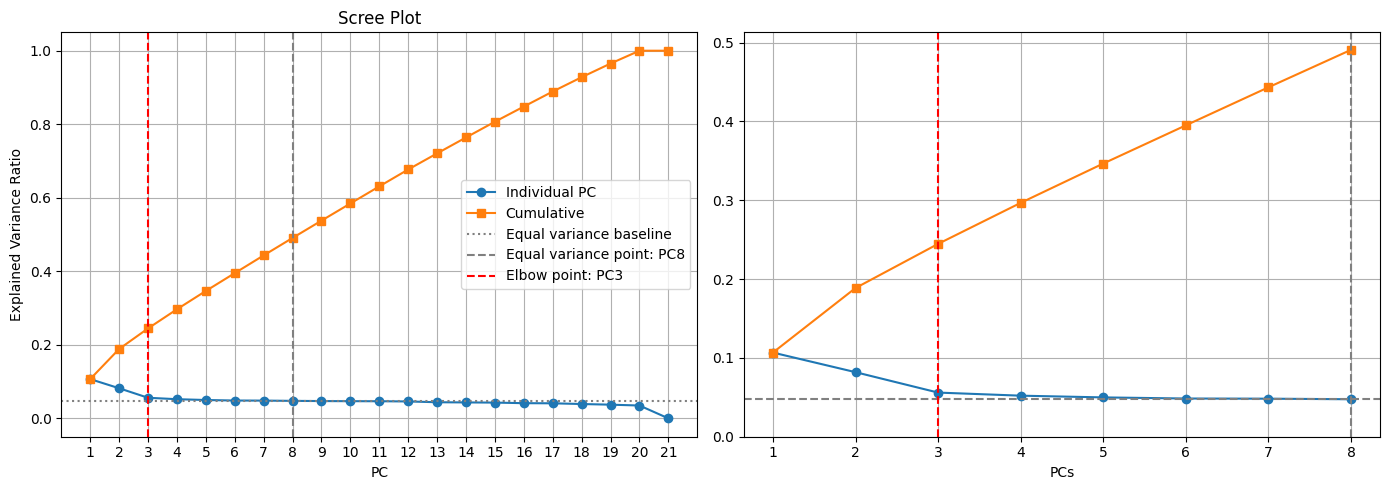

In [11]:
# Data prep
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
pcs = np.arange(1, len(explained_var) + 1)

# Elbow detection via max second derivative
elbow_point = np.argmax(np.diff(np.diff(explained_var))) + 2

# Equal variance baseline cross-over point
equal_variance = 1 / len(explained_var)
equal_variance_point = np.argmax(explained_var <= equal_variance) + 1

# Zoom window (e.g., elbow ±5 PCs)
zoom_start = max(0, elbow_point - 5)
zoom_end = min(len(pcs), elbow_point + 5)
zoom_range = slice(zoom_start, zoom_end)

# Create two subplots WITHOUT shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Full scree plot ---
ax1.plot(pcs, explained_var, marker='o', label='Individual PC')
ax1.plot(pcs, cumulative_var, marker='s', linestyle='-', label='Cumulative')
ax1.axhline(equal_variance, color='gray', linestyle=':', label='Equal variance baseline')
ax1.axvline(equal_variance_point, color='gray', linestyle='--', label=f'Equal variance point: PC{equal_variance_point}')
ax1.axvline(elbow_point, color='red', linestyle='--', label=f'Elbow point: PC{elbow_point}')
ax1.set_xlabel("PC")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Scree Plot")
ax1.set_xticks(pcs)
ax1.legend()
ax1.grid(True)

# --- Right: Zoomed-in plot ---
ax2.plot(pcs[zoom_range], explained_var[zoom_range], marker='o', label='Individual PC')
ax2.plot(pcs[zoom_range], cumulative_var[zoom_range], marker='s', linestyle='-', label='Cumulative')
ax2.axhline(equal_variance, color='gray', linestyle='--', label='Equal variance baseline')
ax2.axvline(equal_variance_point, color='gray', linestyle='--', label=f'Equal variance point: PC{equal_variance_point}')
ax2.axvline(elbow_point, color='red', linestyle='--', label=f'Elbow point: PC{elbow_point}')
ax2.set_ylim(0,None)
ax2.set_xlabel("PCs")
ax2.set_xticks(pcs[zoom_range])
ax2.grid(True)

plt.tight_layout()
plt.show()

# save fig
os.makedirs('/results/figures_astro_PCA', exist_ok=True)
fig.savefig(
    '/results/figures_astro_PCA/astrocyte_clusters_PCA_scree_plot.png',
    dpi=300,
    bbox_inches='tight'
)


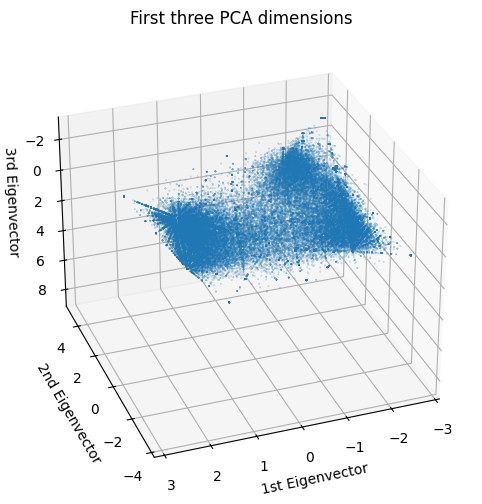

In [12]:
# Scatter plot of all sections PCs

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
scatter = ax.scatter(
    X_pca[:, 0], 
    X_pca[:, 1],
    X_pca[:, 2],
    s=0.05, 
    alpha=0.5
)
ax.set(
    title="First three PCA dimensions",
    xlabel="1st Eigenvector",
    ylabel="2nd Eigenvector",
    zlabel="3rd Eigenvector",
)
plt.show()

## Plot Top 4 PCs in spatial coordinates to look for spatial patterns

21 PCs: PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17, PC18, PC19, PC20, PC21


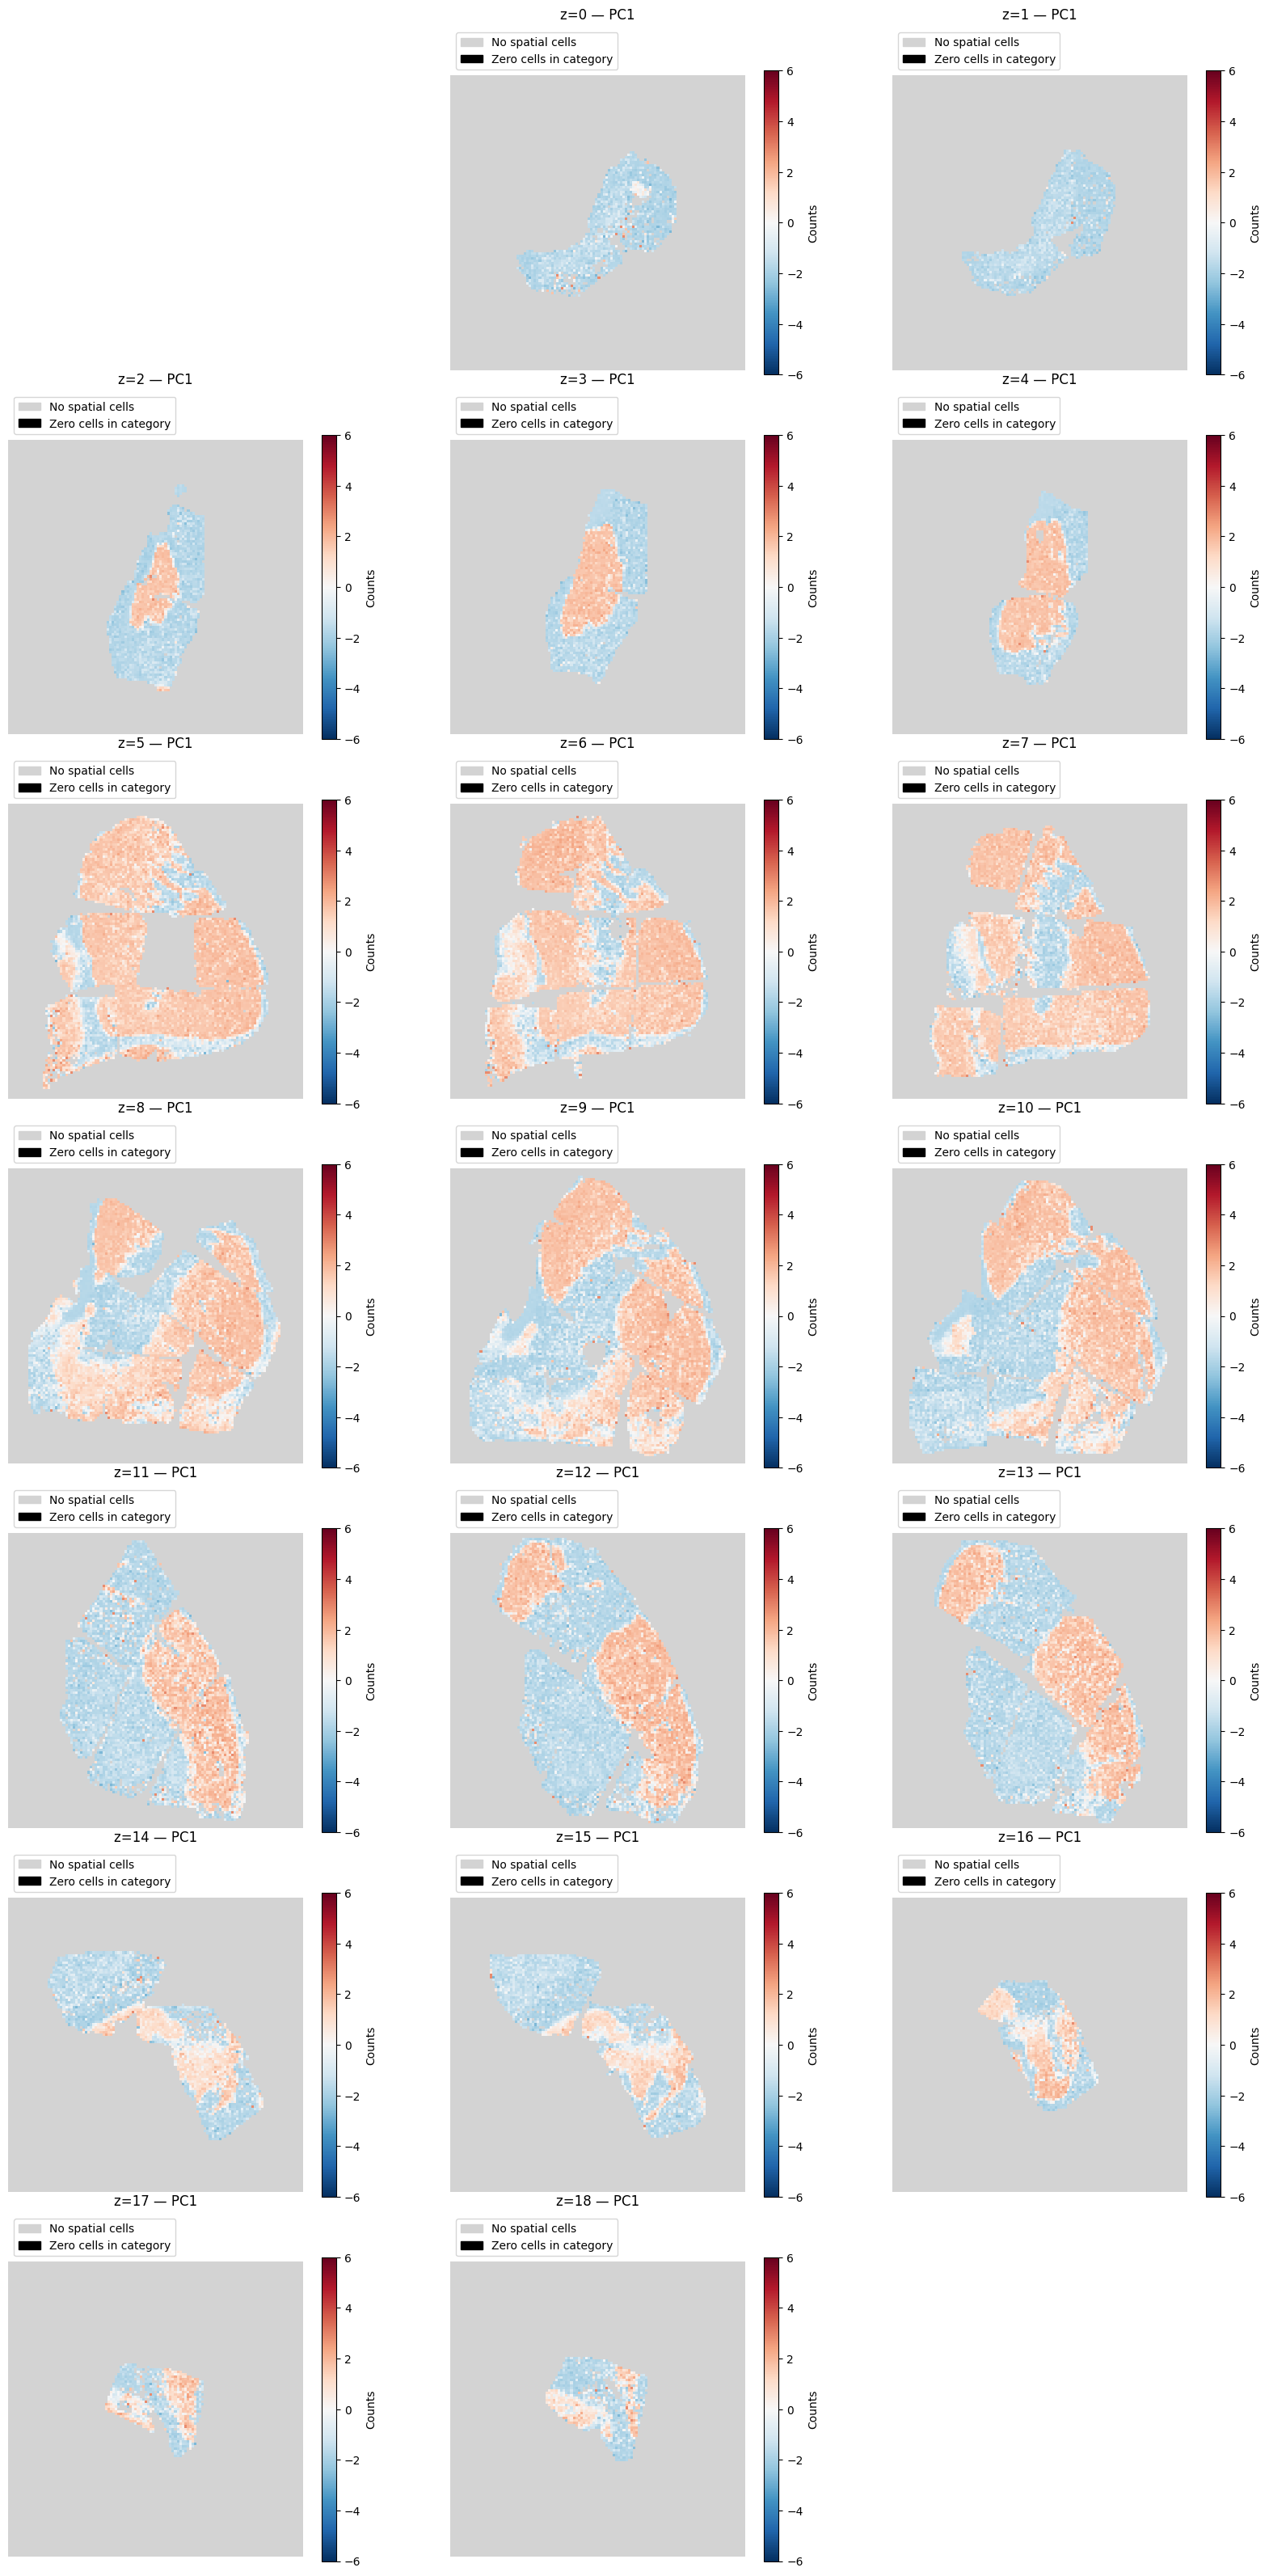

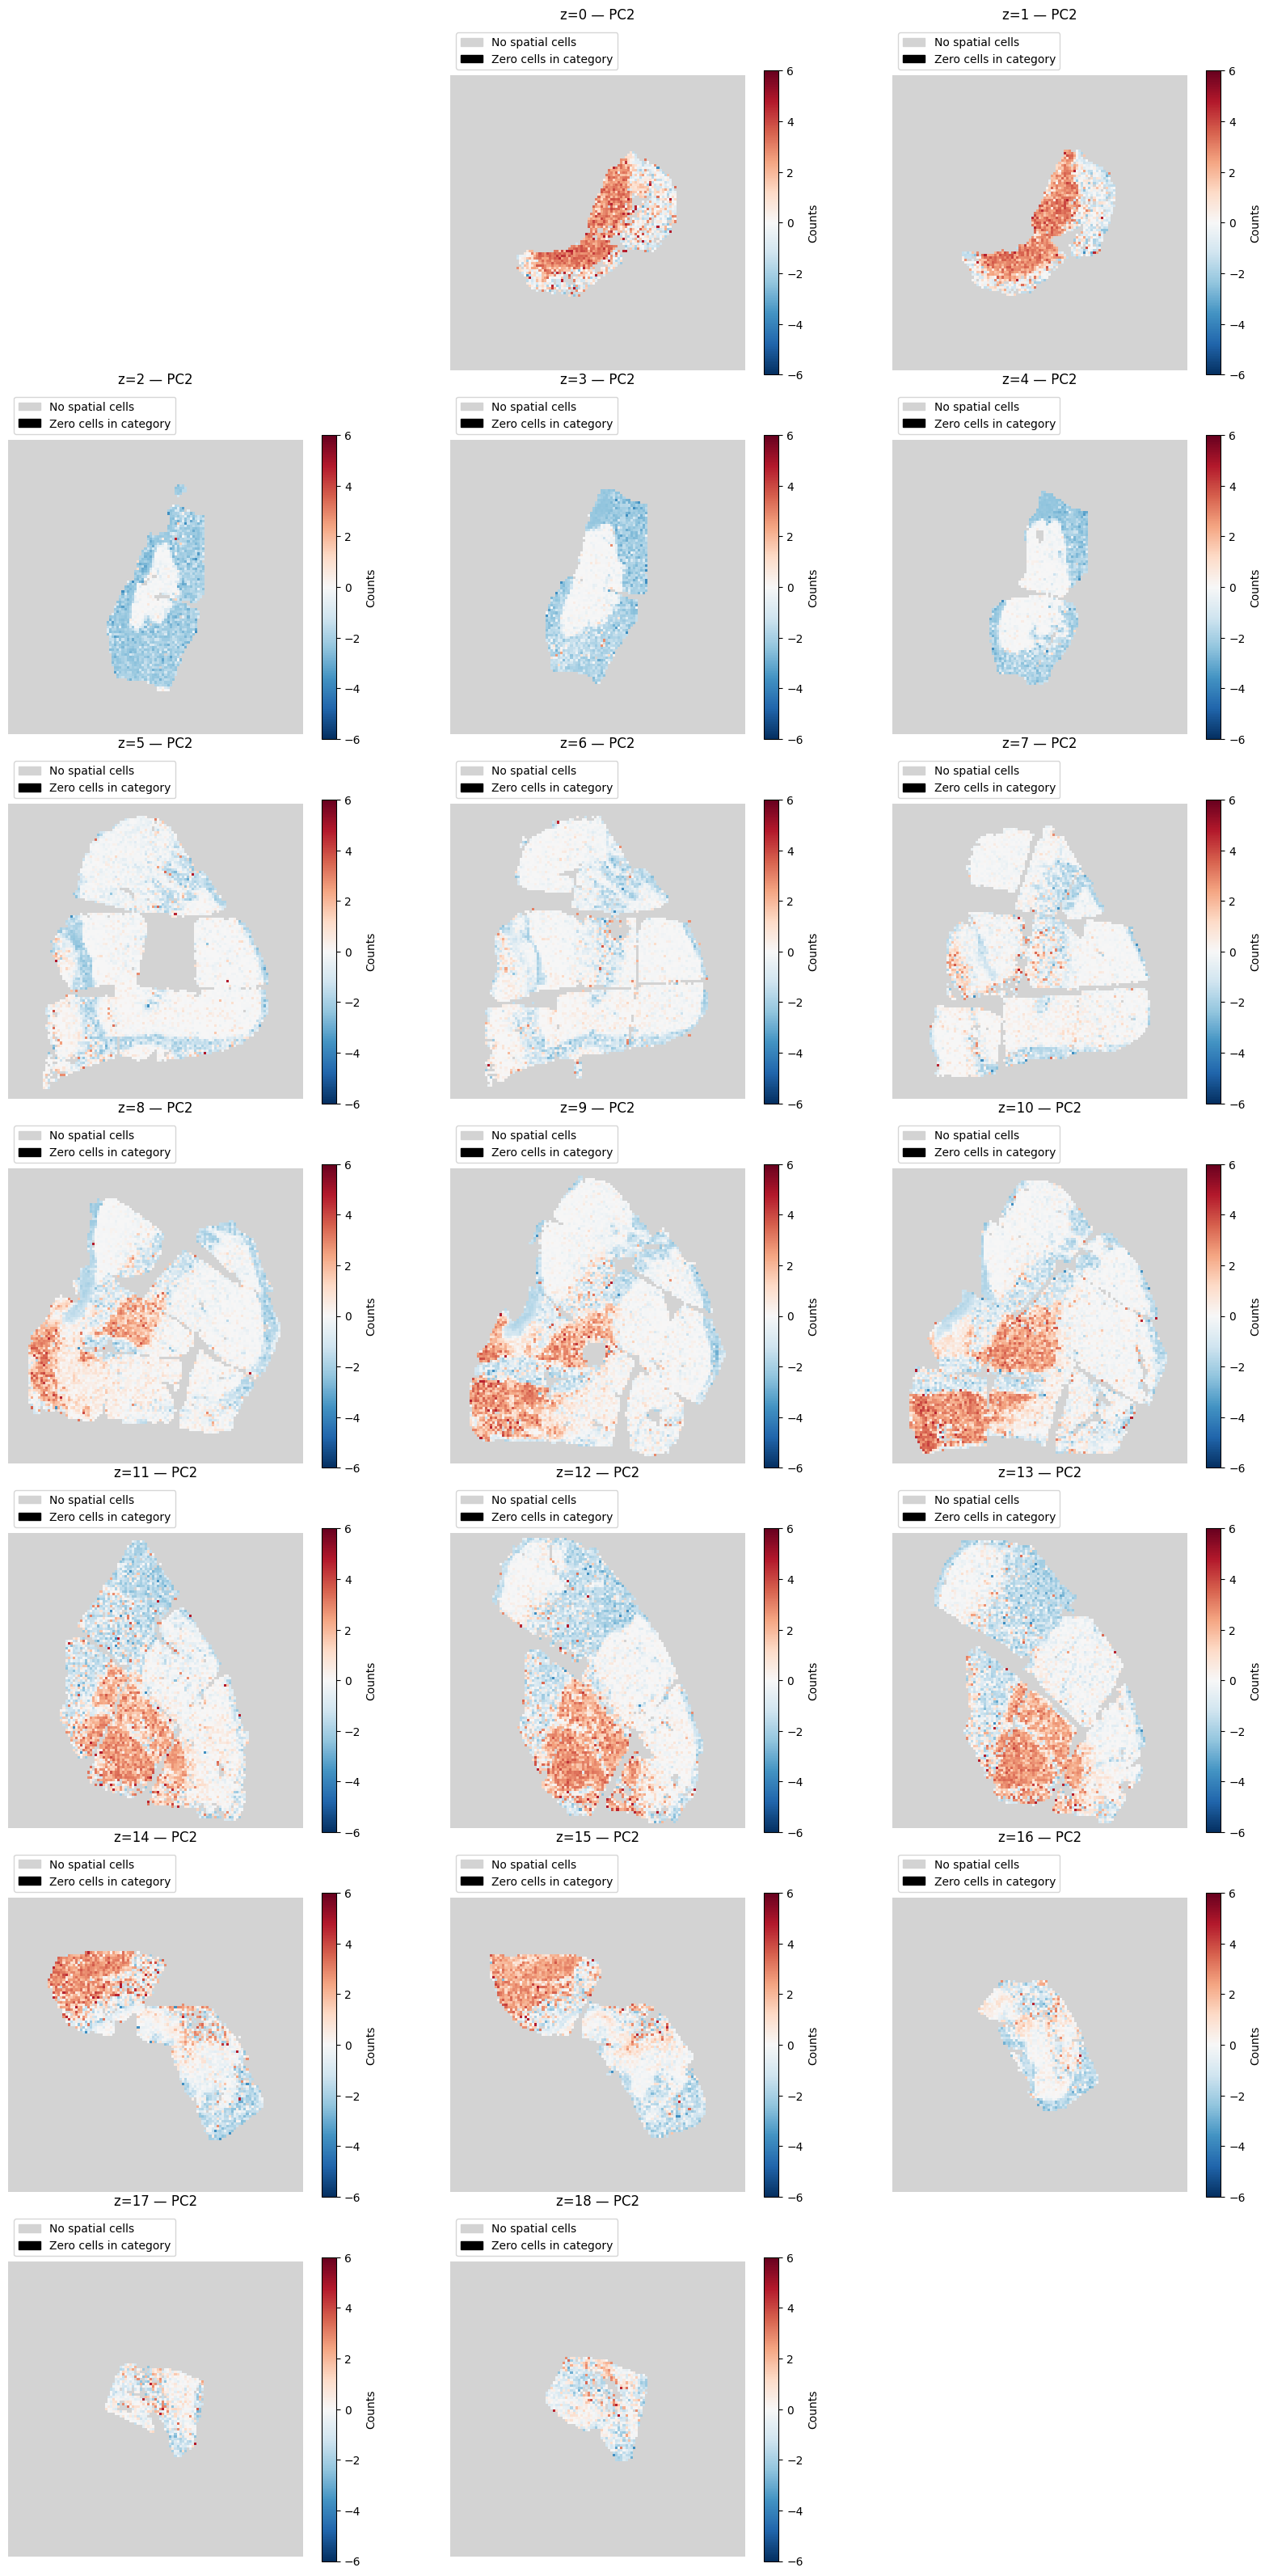

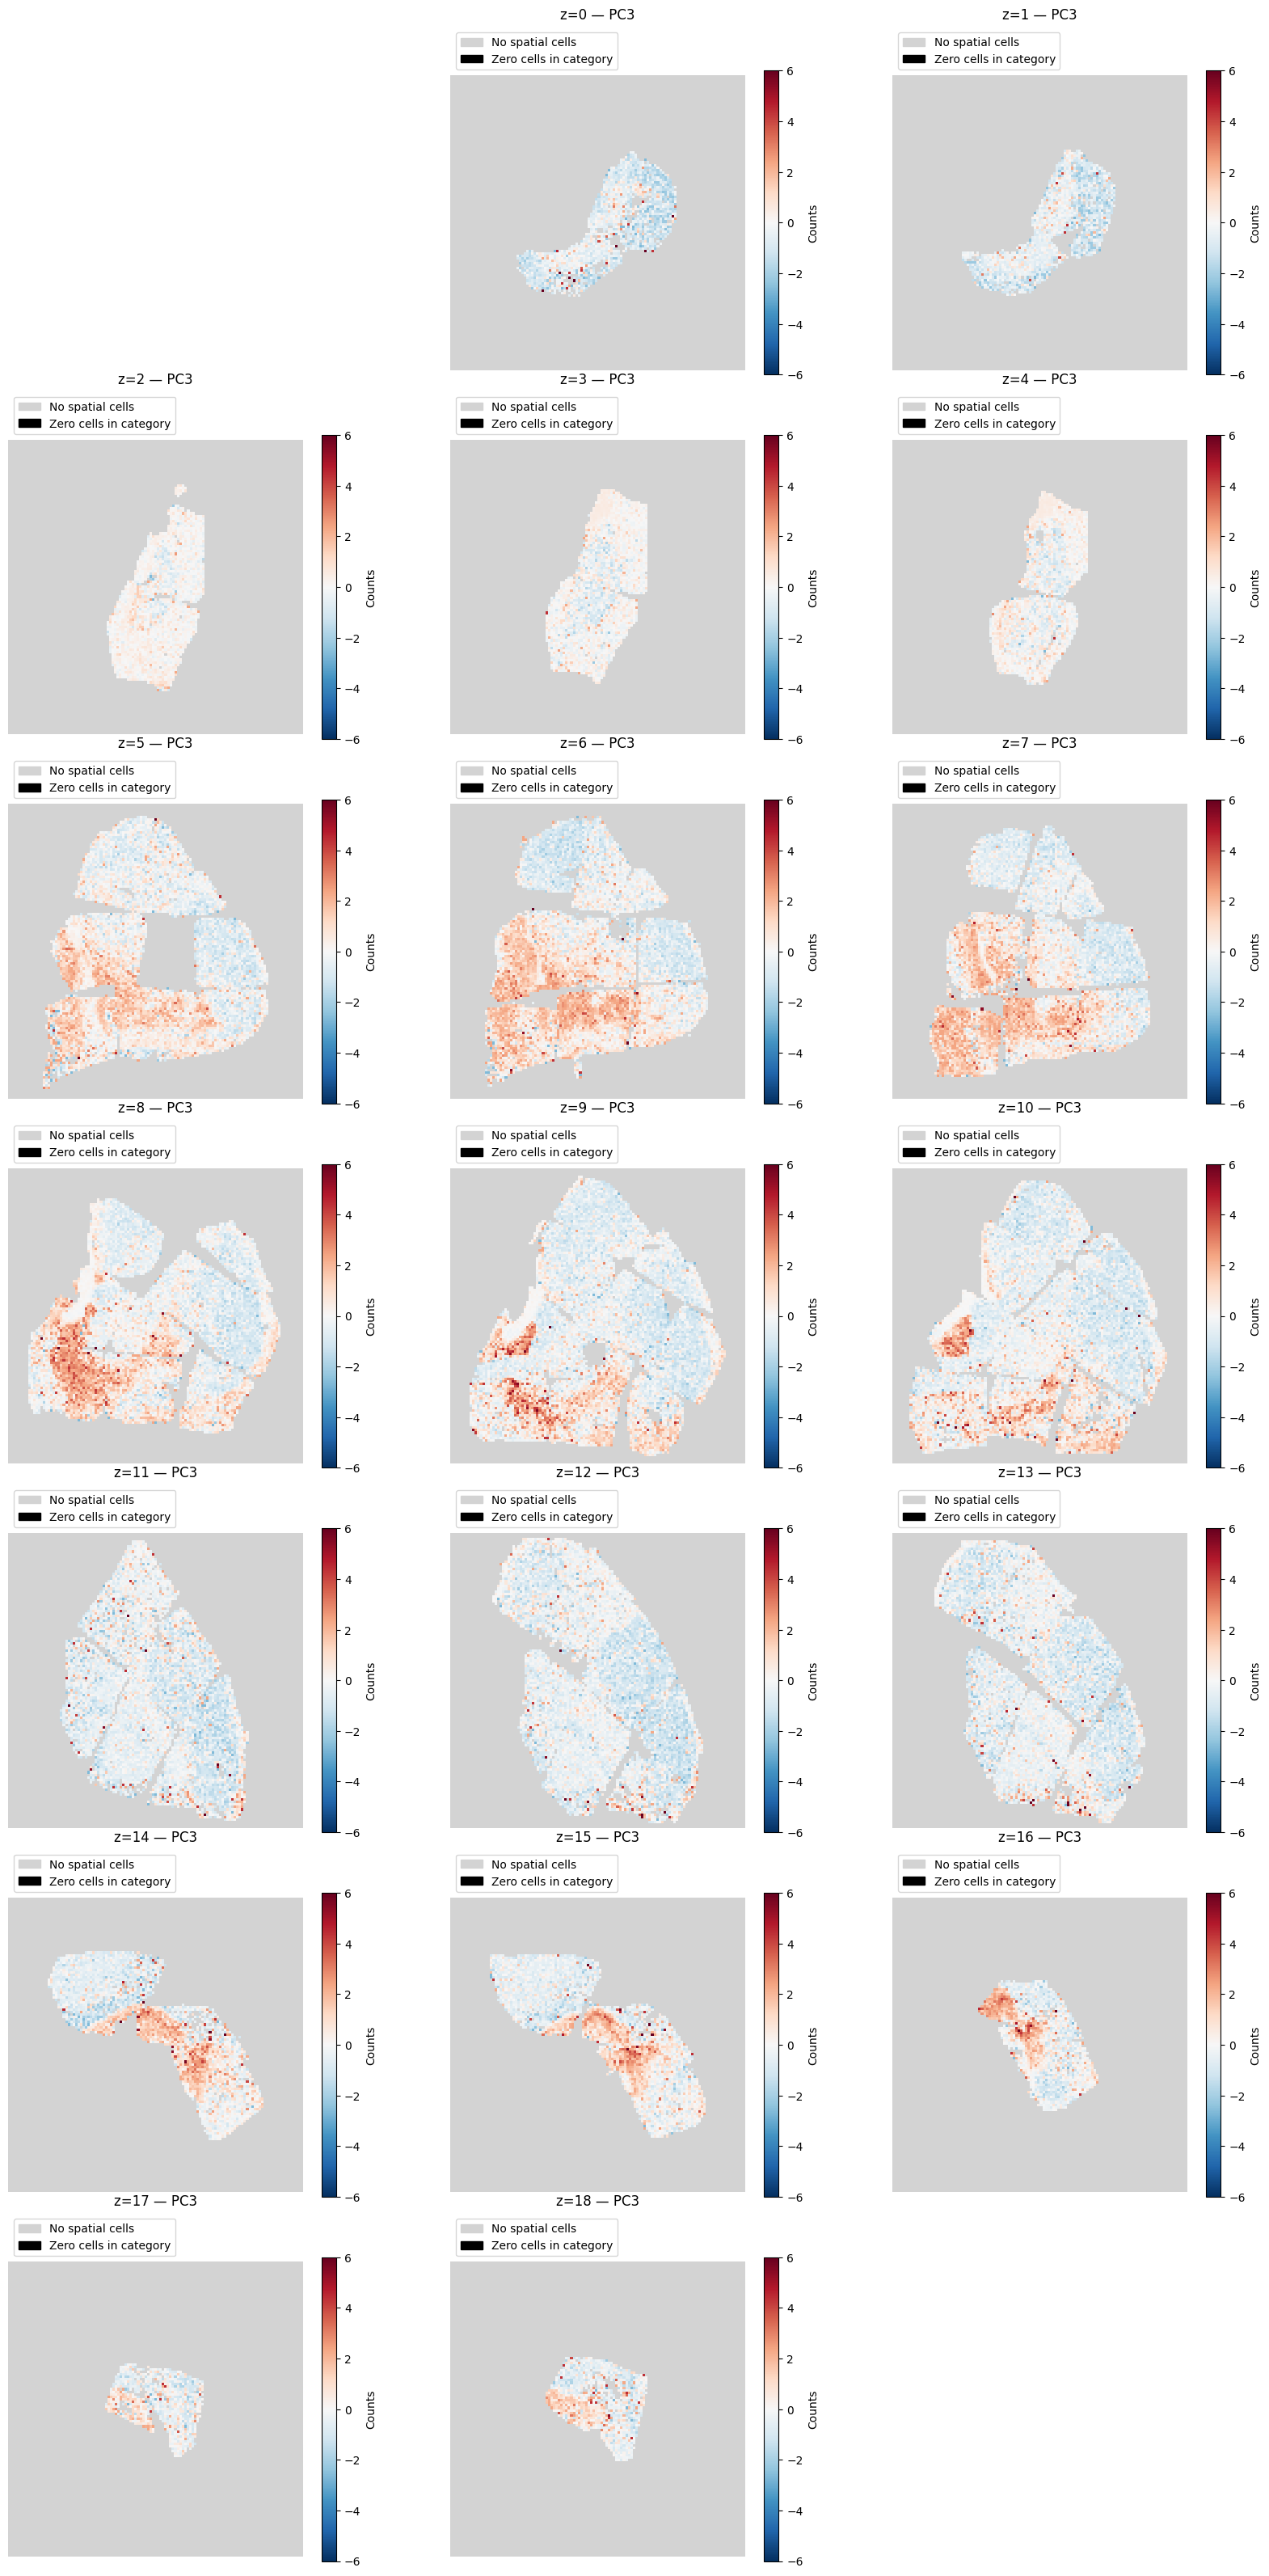

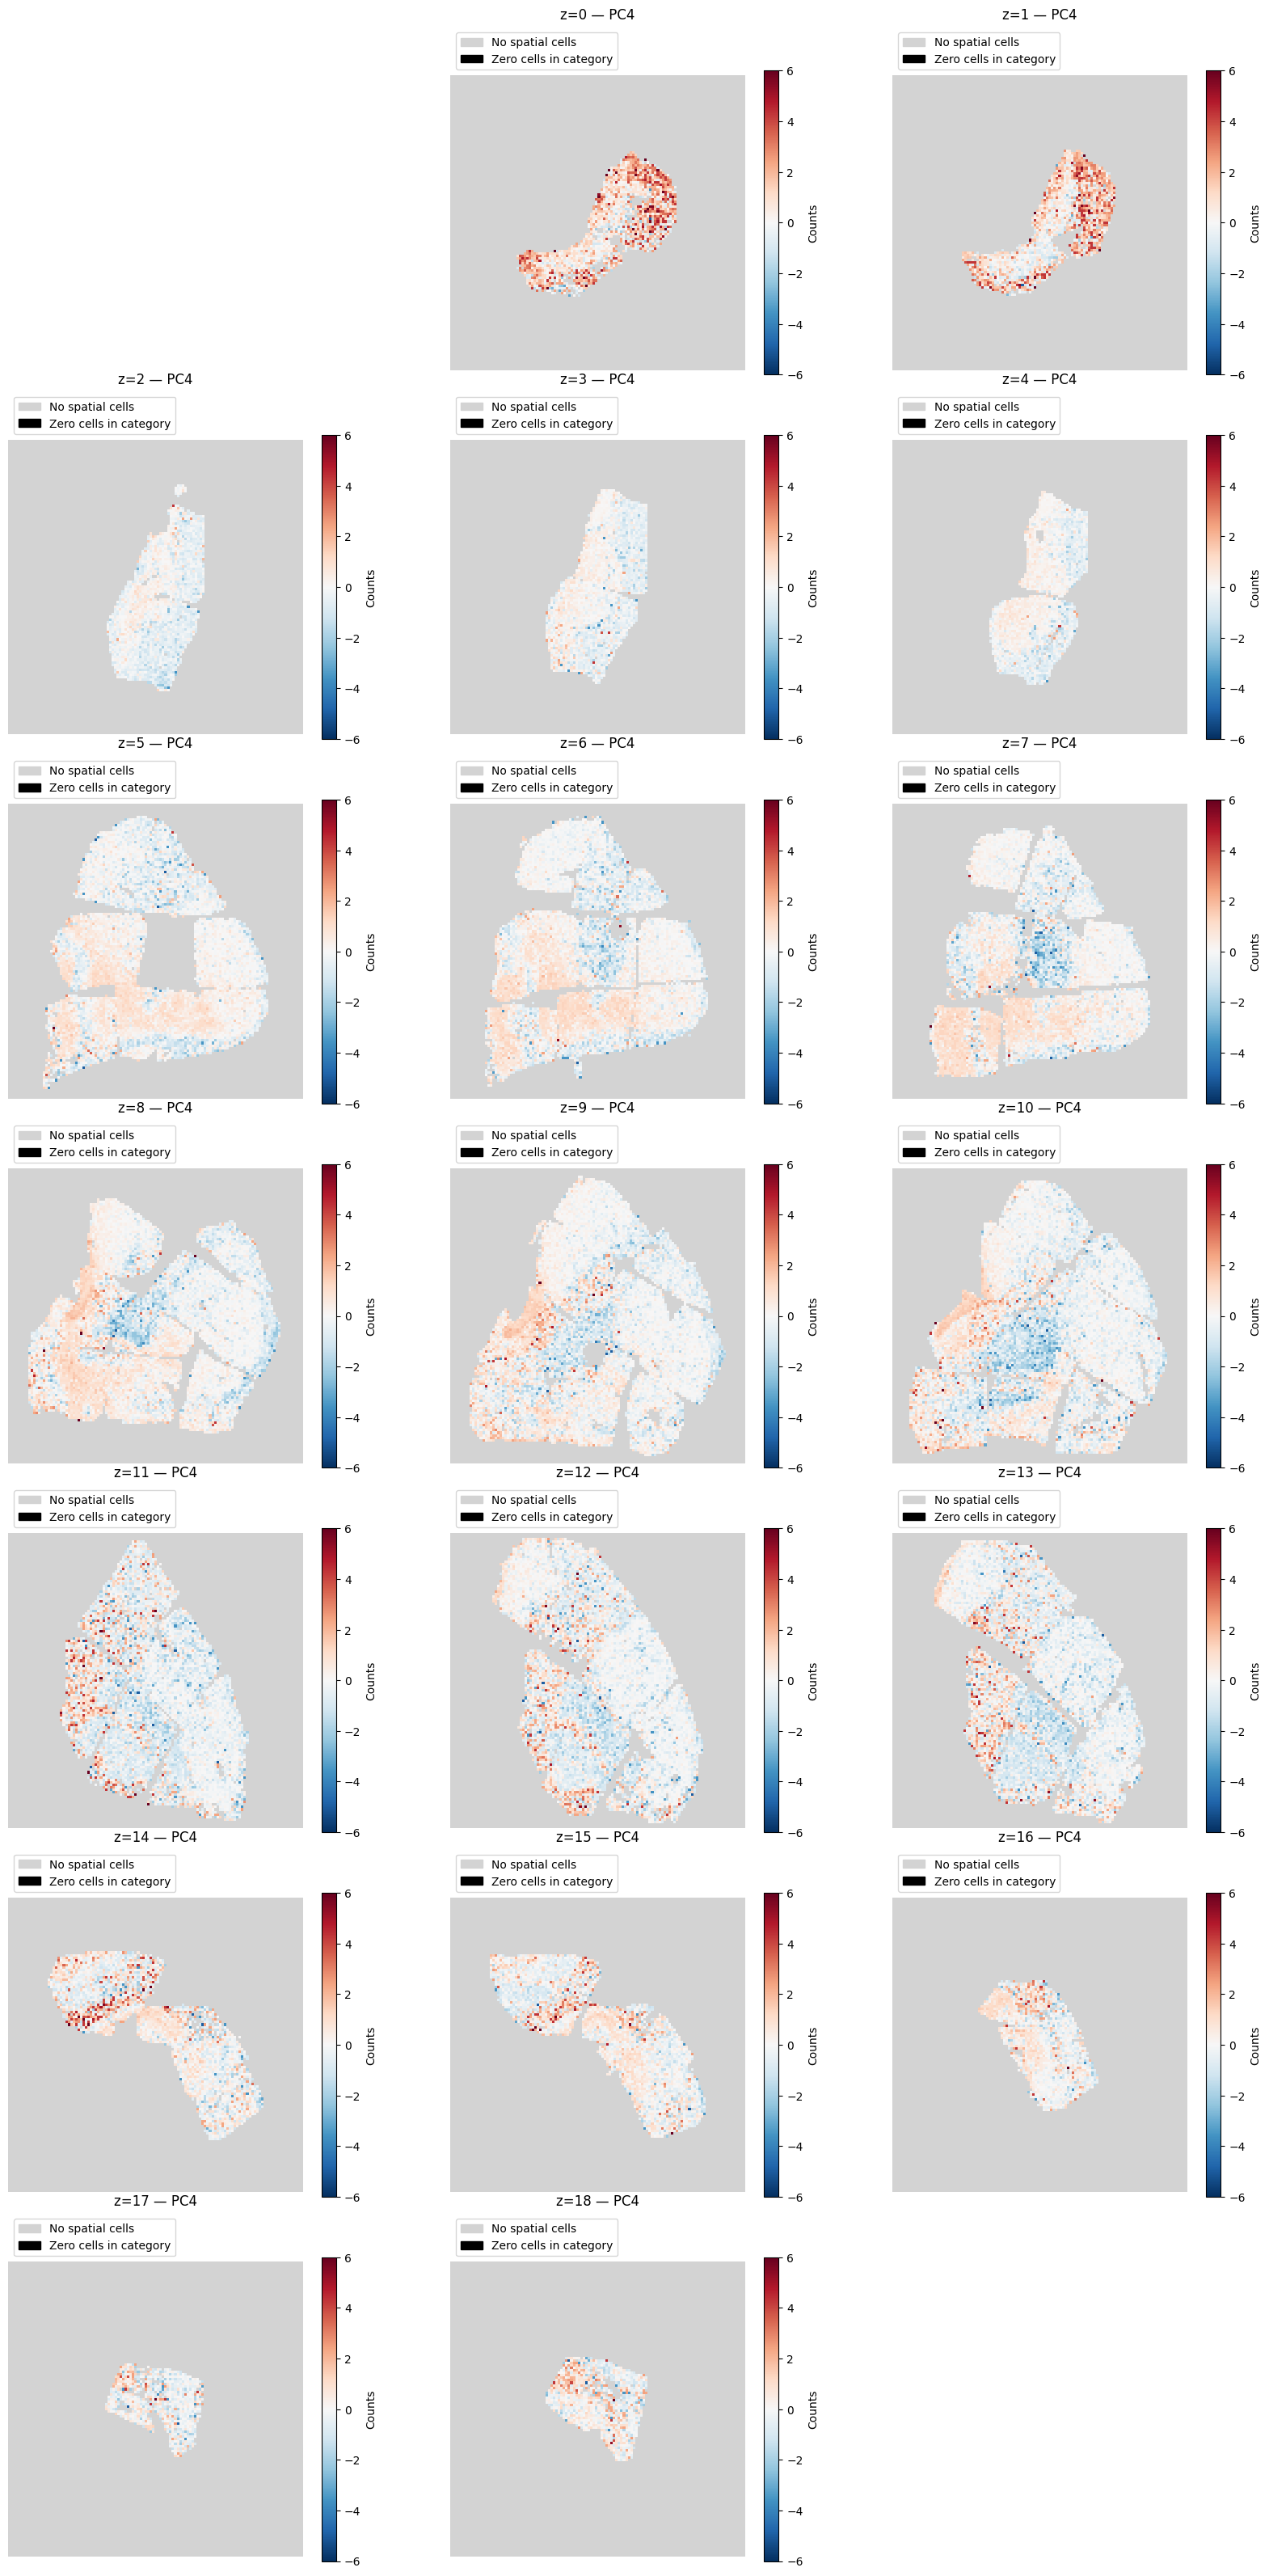

In [13]:
pcs = pca_result[z_sections[0]].coords['pc'].values  # e.g. ['PC1', 'PC2', 'PC3']
print(f"{len(pcs)} PCs: {', '.join(pcs)}")

for pc_name in pcs[:elbow_point+1]:  # or use a specific PC like 'PC1'

    fig, axes = plt.subplots(int(np.ceil(len(z_sections)/3)), 3, figsize=(20, 40))
    axes = axes.flatten()
    used_axes = []

    for i, z in enumerate(z_sections):
        da_pc = pca_result[z]

        # some hacky axis things to get the subplots to look like the layout in .obsm['spatial_grid']
        ind = i+1  # first block/row also only has 2 sections; remaining have 3 sections
        ax = axes[ind]  
        used_axes.append(ind)

        # Extract PC1 values and the bin edges for plotting
        H = da_pc.sel(pc=pc_name).values  # shape (bin_y, bin_x)
        xedges = da_pc.attrs['xedges']
        yedges = da_pc.attrs['yedges']

        histplot.plot_2D_histogram(
            H,
            xedges,
            yedges,
            title=f"z={z} — {pc_name}",
            ax=ax,
            cmap='RdBu_r',
            # vlims=(-np.nanmax(np.abs(H)), np.nanmax(np.abs(H))),
            vlims=(-6,6),
            imshow_size=300*120,
            normalization=None,  # or set a suitable label if you want
        )

    # clean up unused axes
    for j, ax in enumerate(axes):
        if j not in used_axes:
            plt.delaxes(ax)
    plt.show()

    # Save the figure
    os.makedirs("/results/figures_astro_PCA", exist_ok=True)
    fig.savefig(
        f"/results/figures_astro_PCA/astrocyte_clusters_PCA_spatial_hist_{pc_name}.png", 
        dpi=300, 
        bbox_inches='tight'
    )

## PC Loadings - which cell types are contributing to each PC?

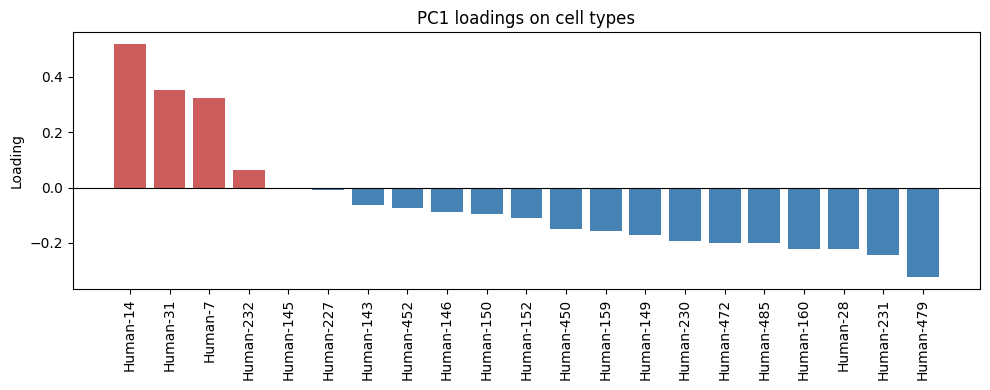

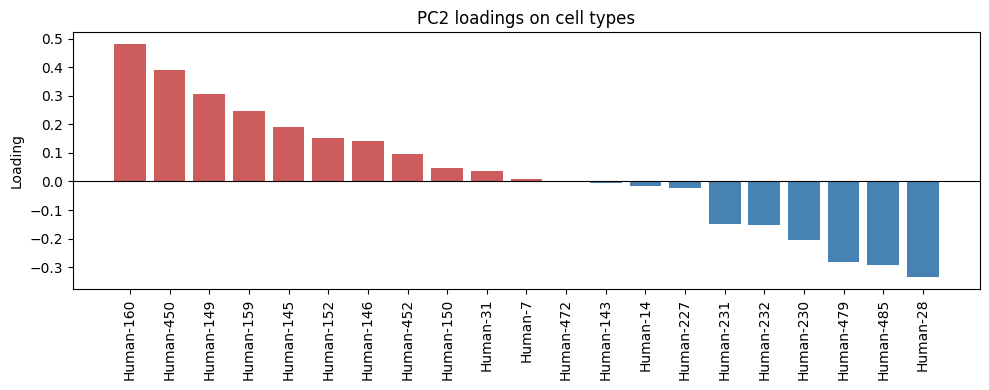

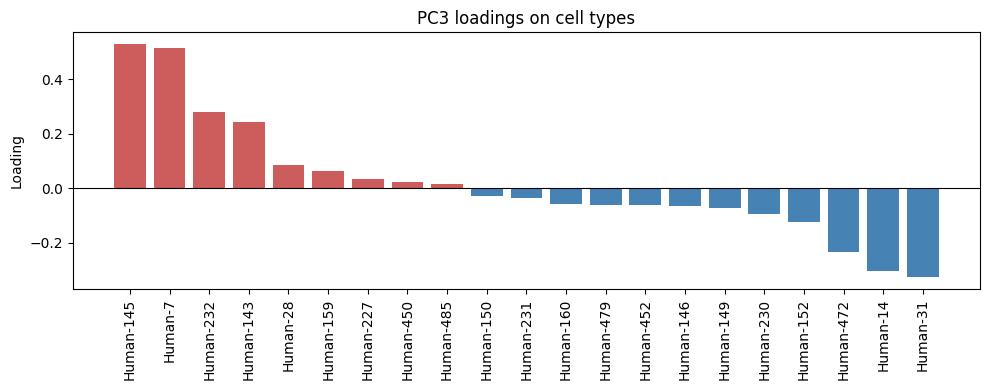

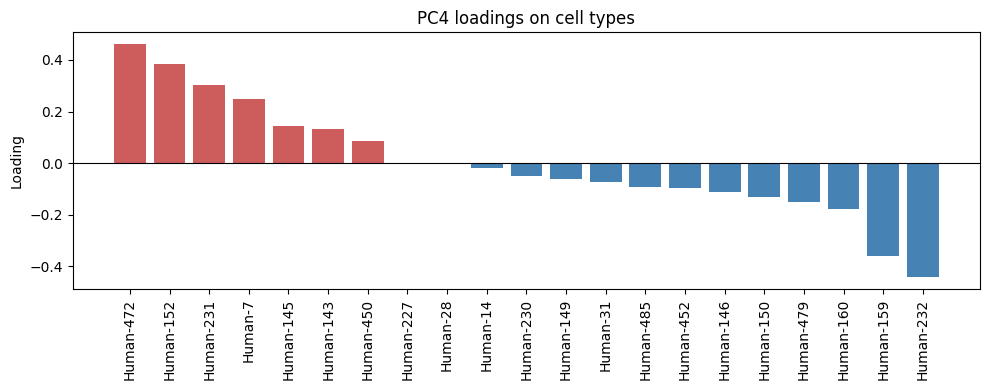

In [14]:
components = pca.components_  # shape (n_components, n_features)
pcs = [f"PC{i+1}" for i in range(components.shape[0])]

for i, pc in enumerate(pcs[:elbow_point+1]):  # or use a specific PC like 'PC1'
    sorted_idx = np.argsort(components[i])[::-1]
    components_sorted = components[i][sorted_idx]
    astro_clusters_sorted = astro_clusters[sorted_idx]
    colors = ['indianred' if v >= 0 else 'steelblue' for v in components_sorted]

    # plt.figure(figsize=(10, 4))
    fig_loadings, ax_loadings = plt.subplots(figsize=(10, 4))
    ax_loadings.bar(range(len(astro_clusters)), components_sorted, tick_label=astro_clusters_sorted, color=colors)
    ax_loadings.axhline(0, color='black', linewidth=0.8)
    plt.xticks(rotation=90)
    plt.ylabel("Loading")
    plt.title(f"{pc} loadings on cell types")
    plt.tight_layout()
    plt.show()

    # Save the figure
    os.makedirs("/results/figures_astro_PCA", exist_ok=True)
    fig_loadings.savefig(
        f"/results/figures_astro_PCA/astrocyte_clusters_PCA_loadings_{pc}.png", 
        dpi=300, 
        bbox_inches='tight'
    )